# Self Attention GAN (SAGAN)

### A PyTorch implementation of Self Attention GAN (SAGAN) with MNIST dataset

### 1. Preparing dataset

In [1]:
BASE = 'D:\\ResearchDataGtx1060\\PracticeData\\MNIST\\'

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

# Utility function to use GPU if exist
def cuda(data):
    if torch.cuda.is_available():
        return data.cuda()
    else:
        return data

# Utility function for help of arranging sample images
def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)
  
# Fix a random latent input for samples
fixed_z = cuda(torch.randn(64, 100))
batch_size = 64

# Define data transformer
img_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Read data and transform
dataset = MNIST(root=BASE, download=True, train=True, transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### 2. Construct self-attention module

Here we will construct the self-attention module that will be used in both generator and discriminator later.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim):
        super().__init__()
        
        # Construct the conv layers
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        
        # Initialize gamma as 0
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1)
        
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B * C * W * H)
            returns :
                out : self attention value + input feature 
                attention: B * N * N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        
        proj_query  = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0,2,1) # B * N * C
        proj_key =  self.key_conv(x).view(m_batchsize, -1, width*height) # B * C * N
        energy =  torch.bmm(proj_query, proj_key) # batch matrix-matrix product
        
        attention = self.softmax(energy) # B * N * N
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height) # B * C * N
        out = torch.bmm(proj_value, attention.permute(0,2,1)) # batch matrix-matrix product
        out = out.view(m_batchsize,C,width,height) # B * C * W * H
        
        # Add attention weights onto input
        out = self.gamma*out + x
        return out, attention

### 3. Generator and discriminator’s structure

We will use Spectral Normalization that is a novel weight normalization technique proposed in “Spectral Normalization for Generative Adversarial Networks” for a more stablized training process. Borrowed from SAGAN’s spectral.py at https://github.com/heykeetae/Self-Attention-GAN.

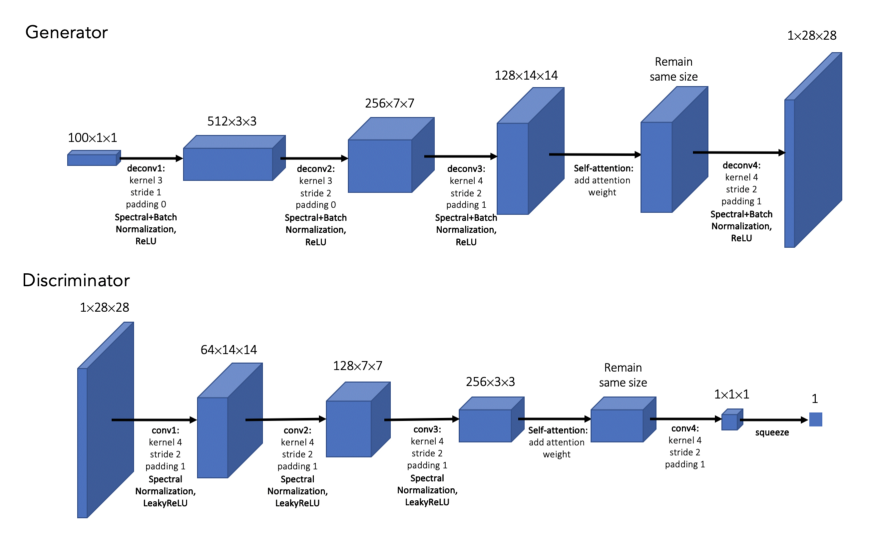

In [ ]:
from spectral import SpectralNorm

class Generator(nn.Module):
    """
    Generator
    input: 
        z: latent matrix with shape of (batch_size, 100)
    output: 
        out: generated image with shape (batch_size, 1, 28, 28)
        p1: attention matrix generated by attn layer
    """
    def __init__(self, batch_size=64, attn=True, image_size=28, z_dim=100, conv_dim=64):
        super().__init__()
        self.attn = attn
        
        # Layer 1 turn 100 dims -> 512 dims, size 1 -> 3
        layer1 = []
        layer1.append(SpectralNorm(nn.ConvTranspose2d(in_channels = z_dim, out_channels = conv_dim*8, kernel_size = 3)))
        layer1.append(nn.BatchNorm2d(conv_dim*8))
        layer1.append(nn.ReLU())
        self.l1 = nn.Sequential(*layer1)
        
        # Layer 2 turn 512 dims -> 256 dims, size 3 -> 7
        layer2 = []
        layer2.append(SpectralNorm(nn.ConvTranspose2d(in_channels = conv_dim*8, out_channels = conv_dim*4, 
                                                      kernel_size = 3, stride = 2, padding = 0)))
        layer2.append(nn.BatchNorm2d(conv_dim*4))
        layer2.append(nn.ReLU())
        self.l2 = nn.Sequential(*layer2)
        
        # Layer 3 turn 256 dims -> 128 dims, size 7 -> 14
        layer3 = []
        layer3.append(SpectralNorm(nn.ConvTranspose2d(in_channels = conv_dim*4, out_channels = conv_dim*2, 
                                                      kernel_size = 4, stride = 2, padding = 1)))
        layer3.append(nn.BatchNorm2d(conv_dim*2))
        layer3.append(nn.ReLU())
        self.l3 = nn.Sequential(*layer3)

        # Layer 4 (Attn) turn 128 dims -> 128 dims
        self.attn = Self_Attn(conv_dim*2)
        
        # Layer 5 turn 128 dims -> 1 dims, size 14 -> 28
        last = []
        last.append(nn.ConvTranspose2d(conv_dim*2, 1, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

    def forward(self, z):
        # z is the input random matrix for generator
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z)
        out=self.l2(out)
        out=self.l3(out)
        if self.attn == True:
            out = self.attn(out)
        out=self.last(out)

        return out


class Discriminator(nn.Module):
    """
    Discriminator
    input:
        x: one batch of data with shape of (batch_size, 1, 28, 28)
    output: 
        out.squeeze: a batch of scalars indicating the predict results
        p1: attention matrix generated by attn layer
    """
    def __init__(self, batch_size=64, attn=True, image_size=28, conv_dim=64):
        super().__init__()
        self.attn = attn
        
        layer1 = []
        layer1.append(SpectralNorm(nn.Conv2d(1, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))
        curr_dim = conv_dim
        self.l1 = nn.Sequential(*layer1)
        
        layer2 = []
        layer2.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2
        self.l2 = nn.Sequential(*layer2)
        
        layer3 = []
        layer3.append(SpectralNorm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2
        self.l3 = nn.Sequential(*layer3)
        
        self.attn = Self_Attn(curr_dim)
        
        last = []
        last.append(nn.Conv2d(curr_dim, 1, 4, 2, 1))
        self.last = nn.Sequential(*last)

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        if self.attn == True:
            out = self.attn(out)
        out=self.last(out)

        return out.squeeze()

### 3. Create a training function

This is usually the most confusing part. Unlike CNNs or other simple machine learning models, GANs does not have a ready-to-use fit function. We need to write the whole training function.

We start by initializing our models and optimizers. Then within a loop, we first read in a batch of data from the DataLoader.

Next step, we feed our discriminator the batch of real images and calculate the hinge loss. Then we use an array of random numbers as latent variables, generate a batch of fake images with the generator, feed them into discriminator again, and get the loss.

As mentioned before, the goal for our discriminator is to give out predictions closer to 1 for real images, and 0 for fake images. Therefore, we want to reduce the sum of (1-predictions for real images) and predictions for fake images. We can achieve this using backward and step, and update all learning parameters for discriminator within a few lines of code thanks to PyTorch.

We then update parameters for the generator using the output of fake images from the discriminator. Voila, one training loop is done and we trained our model for the first batch of images. Print out the log info and save images/models if you want.

In [ ]:
from torchvision.utils import save_image
from IPython.display import clear_output
import torch.nn as nn
import datetime
import time
import os

def train(steps = 10, batch_size = 64, z_dim = 100, attn = True):
    # Initialize model
    G = cuda(Generator(batch_size, attn))
    D = cuda(Discriminator(batch_size, attn))
    
    # Make directory for samples and models
    cwd = os.getcwd()
    post='_attn' if attn else ''
    if not os.path.exists(cwd+'/samples_mnist'+post):
        os.makedirs(cwd+'/samples_mnist'+post)

    # Initialize optimizer with filter, lr and coefficients
    g_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, G.parameters()), 0.0001, [0.0,0.9])
    d_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, D.parameters()), 0.0004, [0.0,0.9])
    
    # Load a batch of data
    Iter = iter(dataloader)
    
    # Start timer
    start_time = time.time()
    
    for step in range(steps):
        # ================== Train D ================== #
        D.train(); G.train()
        try:
            real_images,_ = next(Iter)
        except:
            Iter = iter(dataloader)
            real_images,_ = next(Iter)
        
        # Compute loss with real images
        d_out_real = D(cuda(real_images))
        d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
        
        # Compute loss with fake images
        z = cuda(torch.randn(batch_size, z_dim))
        fake_images = G(z)
        d_out_fake = D(fake_images)
        d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
        
        # Backward + Optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad(); g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================== Train G ================== #
        # Create random noise
        z = cuda(torch.randn(batch_size, z_dim))
        fake_images = G(z)
        g_out_fake = D(fake_images)
        g_loss_fake = - g_out_fake.mean()
        d_optimizer.zero_grad(); g_optimizer.zero_grad()
        g_loss_fake.backward()
        g_optimizer.step()
        
        # Print out log info
        if (step + 1) % 10 == 0:
            elapsed = time.time() - start_time
            expect = elapsed/(step + 1)*(steps-step-1)
            elapsed = str(datetime.timedelta(seconds=elapsed))
            expect = str(datetime.timedelta(seconds=expect))
            clear_output(wait=True)
            print("Elapsed [{}], Expect [{}], step [{}/{}], D_real_loss: {:.4f}, "
                  " ave_generator_gamma: {:.4f}".
                  format(elapsed,expect,step + 1,steps,d_loss_real.item(),G.attn.gamma.mean().item()))
            
            
        
        # Sample images
        if (step + 1) % (100) == 0:
            fake_images= G(fixed_z)
            save_image(denorm(fake_images), os.path.join('./samples_mnist'+post, '{}_fake.png'.format(step + 1)))

### 4. Model performance

Taking samples from the generator every 100 batches, we can see the process of our model learning to draw digits. 

In [ ]:
train()

Source: 

[1] https://towardsdatascience.com/building-your-own-self-attention-gans-e8c9b9fe8e51

[2] https://github.com/franknb/Self-attention-DCGAN